<a href="https://colab.research.google.com/github/shreya0505/BTP_7thSem/blob/main/Apples%26Oranges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set Up**
Download weights from this file to your google drive
https://drive.google.com/drive/folders/18zzpa11c66xgr9kfKZjuV6vL2lTVNnbQ?usp=sharing

Mount google drive to colab

In [2]:
from google.colab import drive
from google.colab import files

drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import plot_model

import numpy as np
import os
from glob import glob
import PIL
from PIL import Image
import zipfile
import random
import matplotlib.pyplot as plt

from shutil import copyfile

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.callbacks import ModelCheckpoint

# **Constants**

In [4]:
# PRETRAINED WEIGHTS
PRE_TRAINED_APPLE = "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/apple.rar"
PRE_TRAINED_ORANGE = "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/orange.rar"
PRE_TRAINED_CAT = "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/cat.rar"
PRE_TRAINED_DOG = "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/dog.rar"

WEIGHTS_FOLDER = '/tmp/weights/'

# APPLE AND ORANGE
SOURCE_DIR_APPLE2ORANGE = "/tmp/apple2orange"

APPLE_TEST_DIR = "/tmp/apple2orange/testA"
ORANGE_TEST_DIR = "/tmp/apple2orange/testB"

APPLE_TRAIN_DIR = "/tmp/apple2orange/trainA"
ORANGE_TRAIN_DIR = "/tmp/apple2orange/trainB"

APPLE_DATASET = "/tmp/dataset/apple/apple_images"
ORANGE_DATASET = "/tmp/dataset/orange/orange_images"
APPLE_DATASET_DIR = "/tmp/dataset/apple"
ORANGE_DATASET_DIR = "/tmp/dataset/orange"

WEIGHTS_APPLE = "/tmp/weights/apple/"
WEIGHTS_ORANGE = "/tmp/weights/orange/"


# CAT AND DOG
SOURCE_DIR_DOG2CAT = "/tmp/PetImages/"

DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"

CATS_DIR = "/tmp/dataset/cat/cat_images"
CATS_PARENT_DIR = "/tmp/dataset/cat"

DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
DOGS_DIR = "/tmp/dataset/dog/dog_images"
DOGS_PARENT_DIR = "/tmp/dataset/dog"

WEIGHTS_CAT_DIR = "/tmp/weights/cat/"
WEIGHTS_DOG_DIR = "/tmp/weights/dog/"

In [5]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 64
Z_DIM = 200 # Dimension of the latent vector (z)
LEARNING_RATE = 0.0005
N_EPOCHS = 60

# **Model**

In [6]:
# ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)

      x = LeakyReLU()(x)
    
  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)

  # Define model output
  encoder_output = Dense(output_dim, name = 'encoder_output')(x)

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)

In [7]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)


# **Load Data**

In [8]:
def transfer_data(SOURCE, DESTINATION):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + "/" + filename
        file_details = os.path.splitext(filename)
        if os.path.getsize(file) > 0:
          if file_details[1]=='.jpg':
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    for filename in files:
        this_file = SOURCE + "/" + filename
        destination = DESTINATION + "/" + filename
        copyfile(this_file, destination)

## **Apple and Orange**

In [9]:
# http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip
!wget --no-check-certificate \
    "http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip" \
    -O "/tmp/apple2orange.zip"

local_zip = '/tmp/apple2orange.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-11-28 07:56:43--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/apple2orange.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78456409 (75M) [application/zip]
Saving to: ‘/tmp/apple2orange.zip’

/tmp/apple2orange.z 100%[===================>]  74.82M  2.95MB/s    in 25s     

2021-11-28 07:57:08 (3.01 MB/s) - ‘/tmp/apple2orange.zip’ saved [78456409/78456409]



In [10]:
if not os.path.exists(APPLE_DATASET):
  os.makedirs(APPLE_DATASET)

if not os.path.exists(ORANGE_DATASET):
  os.makedirs(ORANGE_DATASET)

In [11]:
transfer_data(ORANGE_TRAIN_DIR, ORANGE_DATASET )
transfer_data(ORANGE_TEST_DIR, ORANGE_DATASET )
IMAGES = os.listdir(ORANGE_DATASET)
print('There are',len(IMAGES),'orange images. Here are 5 example filesnames:')
print(IMAGES[:5])

transfer_data(APPLE_TRAIN_DIR, APPLE_DATASET )
transfer_data(APPLE_TEST_DIR, APPLE_DATASET )
IMAGES = os.listdir(APPLE_DATASET)
print('There are',len(IMAGES),'apple images. Here are 5 example filesnames:')
print(IMAGES[:5])

There are 1267 orange images. Here are 5 example filesnames:
['n07749192_8660.jpg', 'n07749192_4130.jpg', 'n07749192_6854.jpg', 'n07749192_4320.jpg', 'n07749192_3209.jpg']
There are 1261 apple images. Here are 5 example filesnames:
['n07740461_4622.jpg', 'n07740461_10508.jpg', 'n07740461_10797.jpg', 'n07740461_971.jpg', 'n07740461_6544.jpg']


In [12]:
NUM_IMAGES = len(os.listdir(ORANGE_DATASET))
orange_data_flow = ImageDataGenerator(rescale=1./255,  
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(ORANGE_DATASET_DIR, 
                                                                            target_size = INPUT_DIM[:2],
                                                                            batch_size = BATCH_SIZE,
                                                                            shuffle = True,
                                                                            class_mode = 'input',)

Found 1267 images belonging to 1 classes.


In [13]:
NUM_IMAGES = len(os.listdir(APPLE_DATASET))
apple_data_flow = ImageDataGenerator(rescale=1./255,  
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(APPLE_DATASET_DIR, 
                                                                            target_size = INPUT_DIM[:2],
                                                                            batch_size = BATCH_SIZE,
                                                                            shuffle = True,
                                                                            class_mode = 'input',)

Found 1261 images belonging to 1 classes.


## **Cat and Dog**

In [14]:
# If the URL doesn't work, visit https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765
# And right click on the 'Download Manually' link to get a new URL to the dataset

# Note: This is a very large dataset and will take time to download

!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2021-11-28 07:57:10--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_3367a.zip
Resolving download.microsoft.com (download.microsoft.com)... 184.27.192.129, 2600:1407:21:2a0::e59, 2600:1407:21:28d::e59
Connecting to download.microsoft.com (download.microsoft.com)|184.27.192.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824894548 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.68M  53.8MB/s    in 14s     

2021-11-28 07:57:24 (54.5 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824894548/824894548]



In [15]:
if not os.path.exists(CATS_DIR):
  os.makedirs(CATS_DIR)

if not os.path.exists(DOGS_DIR):
  os.makedirs(DOGS_DIR)

In [16]:
transfer_data(DOG_SOURCE_DIR, DOGS_DIR )
IMAGES = os.listdir(DOGS_DIR)
print('There are',len(IMAGES),'dog images. Here are 5 example filesnames:')
print(IMAGES[:5])

transfer_data(CAT_SOURCE_DIR, CATS_DIR )
IMAGES = os.listdir(CATS_DIR)
print('There are',len(IMAGES),'cat images. Here are 5 example filesnames:')
print(IMAGES[:5])

11702.jpg is zero length, so ignoring.
There are 12499 dog images. Here are 5 example filesnames:
['71.jpg', '11648.jpg', '1024.jpg', '2739.jpg', '5977.jpg']
666.jpg is zero length, so ignoring.
There are 12499 cat images. Here are 5 example filesnames:
['71.jpg', '11648.jpg', '1024.jpg', '2739.jpg', '5977.jpg']


In [17]:
data_flow_dogs = ImageDataGenerator(rescale=1./255,  
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(DOGS_PARENT_DIR, 
                                                                            target_size = INPUT_DIM[:2],
                                                                            batch_size = BATCH_SIZE,
                                                                            shuffle = True,
                                                                            class_mode = 'input',)

Found 12499 images belonging to 1 classes.


In [18]:
data_flow_cats = ImageDataGenerator(rescale=1./255,  
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest').flow_from_directory(CATS_PARENT_DIR, 
                                                                            target_size = INPUT_DIM[:2],
                                                                            batch_size = BATCH_SIZE,
                                                                            shuffle = True,
                                                                            class_mode = 'input',)

Found 12499 images belonging to 1 classes.


# **Load Pretrained Models**

In [19]:
if not os.path.exists(WEIGHTS_FOLDER):
  os.makedirs(WEIGHTS_FOLDER)

## **Dog**

In [20]:
encoder_input, encoder_output,  shape_before_flattening, dog_encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

dog_encoder.summary()

decoder_input, decoder_output, dog_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
dog_decoder.summary()

# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = dog_decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
dog_simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

dog_simple_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0     

In [21]:
!unrar x "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/dog.rar" "/tmp/weights"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /gdrive/MyDrive/BTP_ImageToImageTranslation/weights/dog.rar

Creating    /tmp/weights/dog                                          OK
Extracting  /tmp/weights/dog/.data-00000-of-00001                         20% 41% 62% 83% 99%  OK 
Extracting  /tmp/weights/dog/.index                                       99%  OK 
Extracting  /tmp/weights/dog/checkpoint                                   99%  OK 
All OK


In [22]:
dog_simple_autoencoder.load_weights(WEIGHTS_DOG_DIR)

## **Cat**

In [23]:
encoder_input, encoder_output,  shape_before_flattening, cat_encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

cat_encoder.summary()

decoder_input, decoder_output, cat_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
cat_decoder.summary()

# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = cat_decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
cat_simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

cat_simple_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0     

In [24]:
!unrar x "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/cat.rar" "/tmp/weights"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /gdrive/MyDrive/BTP_ImageToImageTranslation/weights/cat.rar

Creating    /tmp/weights/cat                                          OK
Extracting  /tmp/weights/cat/.data-00000-of-00001                         20% 41% 62% 83% 99%  OK 
Extracting  /tmp/weights/cat/.index                                       99%  OK 
Extracting  /tmp/weights/cat/checkpoint                                   99%  OK 
All OK


In [25]:
cat_simple_autoencoder.load_weights(WEIGHTS_CAT_DIR)

## **Apple**

In [26]:
encoder_input, encoder_output,  shape_before_flattening, apple_encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

apple_encoder.summary()

decoder_input, decoder_output, apple_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
apple_decoder.summary()

# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = apple_decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
apple_simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

apple_simple_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0     

In [27]:
!unrar x "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/apple.rar" "/tmp/weights"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /gdrive/MyDrive/BTP_ImageToImageTranslation/weights/apple.rar

Creating    /tmp/weights/apple                                        OK
Extracting  /tmp/weights/apple/.data-00000-of-00001                       20% 41% 62% 83% 99%  OK 
Extracting  /tmp/weights/apple/.index                                     99%  OK 
Extracting  /tmp/weights/apple/checkpoint                                 99%  OK 
All OK


In [28]:
apple_simple_autoencoder.load_weights(WEIGHTS_APPLE)


## **Orange** 

In [29]:
encoder_input, encoder_output,  shape_before_flattening, orange_encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

orange_encoder.summary()

decoder_input, decoder_output, orange_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
orange_decoder.summary()

# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = orange_decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
orange_simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

orange_simple_autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 32, 32, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 16, 16, 64)        36928     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 64)        0     

In [30]:
!unrar x "/gdrive/MyDrive/BTP_ImageToImageTranslation/weights/orange.rar" "/tmp/weights"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /gdrive/MyDrive/BTP_ImageToImageTranslation/weights/orange.rar

Creating    /tmp/weights/orange (2)                                   OK
Extracting  /tmp/weights/orange (2)/.data-00000-of-00001                  20% 41% 62% 83% 99%  OK 
Extracting  /tmp/weights/orange (2)/.index                                99%  OK 
Extracting  /tmp/weights/orange (2)/checkpoint                            99%  OK 
All OK


In [32]:
# Change name of "tmp/weights/orange (2)" to "tmp/weights/orange"
orange_simple_autoencoder.load_weights(WEIGHTS_ORANGE)

# **Train Further**

In [33]:
def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

## **Apple**

In [34]:
apple_optimizer = Adam(learning_rate = LEARNING_RATE)
apple_simple_autoencoder.compile(optimizer=apple_optimizer, loss = r_loss)
apple_checkpoint_ae = ModelCheckpoint(filepath = WEIGHTS_APPLE, save_weights_only = True, verbose=1)

In [35]:
NUM_IMAGES = len(os.listdir(APPLE_DATASET))
apple_history = apple_simple_autoencoder.fit(apple_data_flow, 
                                 shuffle=True, 
                                 epochs = N_EPOCHS, 
                                 validation_data = apple_data_flow,
                                 initial_epoch = 0, 
                                 steps_per_epoch= int(NUM_IMAGES/BATCH_SIZE),
                                 callbacks=[apple_checkpoint_ae])

Epoch 1/60
19/19 [==============================] - ETA: 0s - loss: 0.0148
Epoch 00001: saving model to /tmp/weights/apple/
19/19 [==============================] - 25s 835ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 2/60
19/19 [==============================] - ETA: 0s - loss: 0.0148
Epoch 00002: saving model to /tmp/weights/apple/
19/19 [==============================] - 15s 809ms/step - loss: 0.0148 - val_loss: 0.0149
Epoch 3/60
19/19 [==============================] - ETA: 0s - loss: 0.0147
Epoch 00003: saving model to /tmp/weights/apple/
19/19 [==============================] - 15s 808ms/step - loss: 0.0147 - val_loss: 0.0145
Epoch 4/60
19/19 [==============================] - ETA: 0s - loss: 0.0146
Epoch 00004: saving model to /tmp/weights/apple/
19/19 [==============================] - 15s 815ms/step - loss: 0.0146 - val_loss: 0.0144
Epoch 5/60
19/19 [==============================] - ETA: 0s - loss: 0.0142
Epoch 00005: saving model to /tmp/weights/apple/
19/19 [=============

In [36]:
!zip -r /content/apple.zip /tmp/weights/apple

  adding: tmp/weights/apple/ (stored 0%)
  adding: tmp/weights/apple/checkpoint (deflated 34%)
  adding: tmp/weights/apple/.index (deflated 72%)
  adding: tmp/weights/apple/.data-00000-of-00001 (deflated 8%)


In [37]:
files.download("/content/apple.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

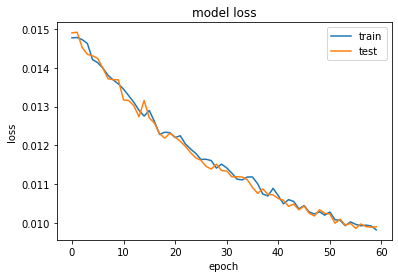

In [43]:
# Plotting loss value decrease
plt.plot(apple_history.history['loss'])
plt.plot(apple_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


### **Orange**

In [51]:
orange_optimizer = Adam(learning_rate = LEARNING_RATE)
orange_simple_autoencoder.compile(optimizer=orange_optimizer, loss = r_loss)
orange_checkpoint_ae = ModelCheckpoint(filepath= WEIGHTS_ORANGE, save_weights_only = True, verbose=1)



In [52]:
NUM_IMAGES = len(os.listdir(ORANGE_DATASET))
orange_history = orange_simple_autoencoder.fit(orange_data_flow, 
                                 shuffle=True, 
                                 epochs = N_EPOCHS, 
                                 initial_epoch = 0, 
                                 validation_data = orange_data_flow,
                                 steps_per_epoch= NUM_IMAGES/BATCH_SIZE,
                                 callbacks=[orange_checkpoint_ae])

Epoch 1/60
20/19 [==============================] - ETA: 0s - loss: 0.0138
Epoch 00001: saving model to /tmp/weights/orange/
19/19 [==============================] - 17s 829ms/step - loss: 0.0138 - val_loss: 0.0138
Epoch 2/60
20/19 [==============================] - ETA: 0s - loss: 0.0140
Epoch 00002: saving model to /tmp/weights/orange/
19/19 [==============================] - 15s 787ms/step - loss: 0.0140 - val_loss: 0.0139
Epoch 3/60
20/19 [==============================] - ETA: 0s - loss: 0.0138
Epoch 00003: saving model to /tmp/weights/orange/
19/19 [==============================] - 15s 788ms/step - loss: 0.0138 - val_loss: 0.0136
Epoch 4/60
20/19 [==============================] - ETA: 0s - loss: 0.0135
Epoch 00004: saving model to /tmp/weights/orange/
19/19 [==============================] - 15s 789ms/step - loss: 0.0135 - val_loss: 0.0134
Epoch 5/60
20/19 [==============================] - ETA: 0s - loss: 0.0134
Epoch 00005: saving model to /tmp/weights/orange/
19/19 [========

In [53]:
!zip -r /content/orange.zip /tmp/weights/orange

  adding: tmp/weights/orange/ (stored 0%)
  adding: tmp/weights/orange/checkpoint (deflated 34%)
  adding: tmp/weights/orange/.index (deflated 72%)
  adding: tmp/weights/orange/.data-00000-of-00001 (deflated 8%)


In [54]:
files.download("/content/orange.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

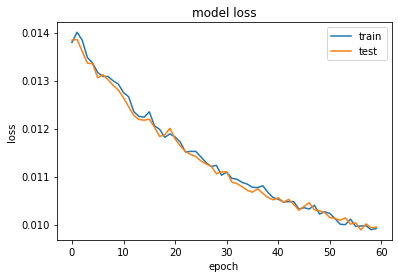

In [55]:
# Plotting loss value decrease
plt.plot(orange_history.history['loss'])
plt.plot(orange_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


# **Results**

In [56]:
def plot_compare(images=None, add_noise=False, encoder=None, decoder=None, simple_autoencoder=None):
  
  if ( (images is None) or (encoder is None) or (decoder is None) or (simple_autoencoder is None)):
    print("Invalid Inputs")
    raise ValueError

  n_to_show = images.shape[0]

  if add_noise:
    encodings = encoder.predict(images)
    encodings += np.random.normal(0.0, 1.0, size = (n_to_show,200))
    reconst_images = decoder.predict(encodings)

  else:
    reconst_images = simple_autoencoder.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)

## **Expected Input**

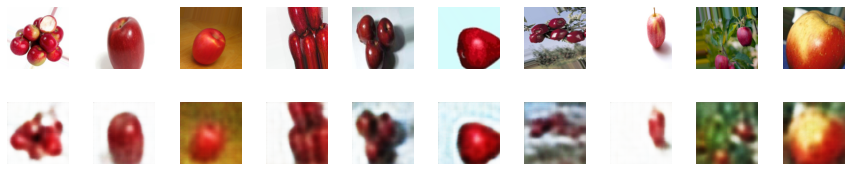

In [57]:
apple_batch = next(apple_data_flow)
apple_batch = apple_batch[0]
apple_images = apple_batch[:10]

plot_compare(apple_images, False, apple_encoder, apple_decoder, apple_simple_autoencoder)

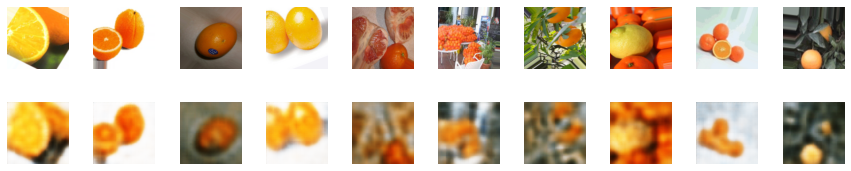

In [58]:
orange_batch = next(orange_data_flow)
orange_batch = orange_batch[0]
orange_images = orange_batch[:10]

plot_compare(orange_images, False, orange_encoder, orange_decoder, orange_simple_autoencoder)

## **Swapped Input**

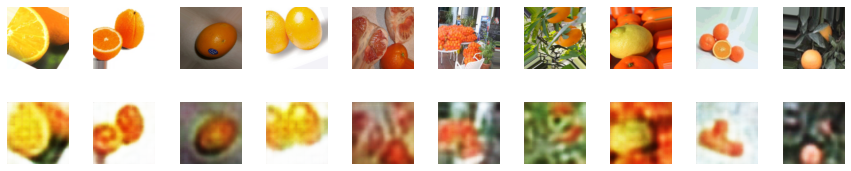

In [59]:
plot_compare(orange_images, False, apple_encoder, apple_decoder, apple_simple_autoencoder)

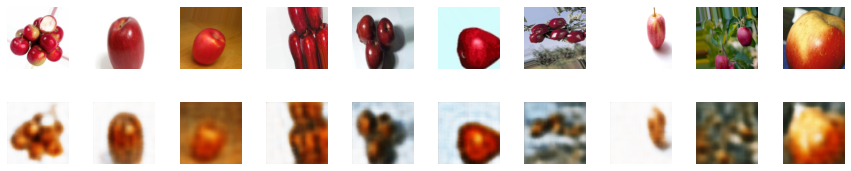

In [60]:
plot_compare(apple_images, False, orange_encoder, orange_decoder, orange_simple_autoencoder)